<a href="https://colab.research.google.com/github/ayuka-kitsuda/AI_Portfolio_Applications/blob/main/ImageRecognitionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ayuka-kitsuda/AI_Portfolio_Applications/blob/main/ImageRecognitionModel.ipynb
)


<h1>画像認識アプリのモデルを作成</h1>

画像の前処理
--
- データの前処理  
- データセットの取得  
- DataLoaderの設定

In [ ]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(256),  # 短い方の辺を256に
    transforms.CenterCrop(224),  # 辺の長さが224の正方形を中央から切り抜く
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform)

# DataLoaderの設定
batch_size = 128
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 29924502.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


モデルを取得
--
- Viaion Transformerモデルを取得
- ImageNetで学習された重みを使用

In [ ]:
import torchvision.models as models
from torchvision.models import ViT_B_16_Weights

net = models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
print(net)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 133MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

パラメータを変更
--
- 出力層に合わせるため、モデルのパラメータを変更
- GPU対応

In [ ]:
import torch.nn as nn

# 全ての層のパラメータを訓練不可に
for param in net.parameters():
    param.requires_grad = False

# 一部の層を入れ替え（デフォルトで訓練可能）
net.heads[0] = nn.Linear(768, 10)

net.cuda()  # GPU対応
print(net)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

モデルの学習
--
- 損失関数と最適化アルゴリズムの設定
- モデルの学習
- モデルの評価
- エポックごとの結果を表示

In [ ]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)


# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(6):  # 6エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 0.2914903854470119 Loss_Test: 0.18445677102743824
Epoch: 1 Loss_Train: 0.1588048177492588 Loss_Test: 0.16630065912687325
Epoch: 2 Loss_Train: 0.1392812175995401 Loss_Test: 0.15824686056828197
Epoch: 3 Loss_Train: 0.12768084029941 Loss_Test: 0.15305794275636914
Epoch: 4 Loss_Train: 0.11944298318508641 Loss_Test: 0.15290851155413857
Epoch: 5 Loss_Train: 0.11364140130026872 Loss_Test: 0.1499395688311963


グラフ表示
--
- 学習データとテストデータの損失誤差をグラフで可視化

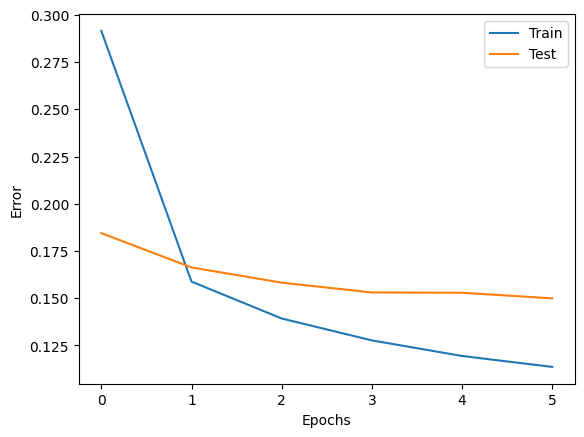

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

モデルの正解率
--
- モデルの正解率を表示

In [ ]:
correct = 0
total = 0
net.eval()
for i, (x, t) in enumerate(test_loader):
  x, t = x.cuda(), t.cuda()
  y = net(x)
  correct += (y.argmax(1) == t).sum().item()
  total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 94.93%


モデルを保存
--

In [ ]:
import torch

# モデルを保存
torch.save(net.state_dict(), "trained_model.pth")
print("モデルの保存が完了しました。")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
モデルの保存が完了しました。
